[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)

# based on Fig 2. in [Fisher 1991](https://doi.org/10.3402/tellusb.v43i5.15414)
Deuterium excess $d=\delta(D) - 8\delta( ^{18}O)$

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from matplotlib import pyplot
import numpy as np
from open_atmos_jupyter_utils import show_plot
from scipy.integrate import solve_ivp
from functools import partial

from PySDM import Formulae
from PySDM.physics import si
from PySDM.physics.constants import PER_MILLE, in_unit
from PySDM_examples.Jouzel_and_Merlivat_1984.thermodynamic_profiles import (
    vapour_mixing_ratio,
    ice_saturation_curve_4,
    A_coefficient
)

In [3]:
formulae= Formulae(
    isotope_meteoric_water_line="Dansgaard1964",
    isotope_diffusivity_ratios="Stewart1975",
    isotope_kinetic_fractionation_factors="BolotEtAl2013",
    isotope_equilibrium_fractionation_factors="MerlivatAndNief1967+Majoube1970",
)
const = formulae.constants

In [14]:
def Si_fun(T, Si_type):
    if Si_type == 'eff':
        Si = formulae.isotope_kinetic_fractionation_factors.effective_supersaturation(A_coefficient(T),ice_saturation_curve_4(formulae.constants, T=T))
    elif Si_type == 'non-eff':
        Si = ice_saturation_curve_4(formulae.constants, T=T)
    return Si

In [15]:
def alpha_eff(T, alpha_s, diffusivity_ratio, Si_type):
    a = alpha_s(T=T)
    a *= formulae.isotope_kinetic_fractionation_factors.alpha_kinetic(
        alpha_equilibrium=a,
        saturation_over_ice=Si_fun(T=T, Si_type=Si_type),
        heavy_to_light_diffusivity_ratio=diffusivity_ratio,
    )
    return a

In [16]:
def d_delta_dT(T, delta, Si_type):
    y = yf(T=T)
    dT = 1 * si.K
    dy_dT = (yf(T=T + dT) - y) / dT
    res = [0, 0]
    for i, isotope in enumerate(isotopes):
        D_ratio = (
            formulae.isotope_diffusivity_ratios.ratio_2H(T)
            if isotope == "2H"
            else formulae.isotope_diffusivity_ratios.ratio_18O(T)
        )
        alpha = alpha_eff(
            T=T, alpha_s=alpha_eq[isotope], diffusivity_ratio=D_ratio, Si_type=Si_type
        )
        alpha_dT = alpha_eff(
            T=T + dT, alpha_s=alpha_eq[isotope], diffusivity_ratio=D_ratio, Si_type=Si_type
        )
        d_alpha_dT = (alpha_dT - alpha) / dT
        res[i] = (
            (1 + delta[i])
            * (alpha * (alpha - 1) * dy_dT + y * d_alpha_dT)
            / (alpha * (y + alpha * y_e))
        )
    return res

In [17]:
delta_18O_0 = -15 * PER_MILLE
delta_2H_0 = const.CRAIG_1961_SLOPE_COEFF * delta_18O_0
temperature = np.linspace(263, 223, 25) * si.K
isotopes = ("2H", "18O")

In [18]:
y_e = 0
yf = partial(vapour_mixing_ratio, const=const, svp=formulae.saturation_vapour_pressure)
alpha_eq = {}
for iso in isotopes:
    alpha_eq[iso] = getattr(
        formulae.isotope_equilibrium_fractionation_factors, f"alpha_i_{iso}"
    )

In [19]:
Si_choices=('no-eff', 'eff')
delta_2H = {}
delta_18O = {}
d_excess = {}
for Si_choice in Si_choices:
    result = solve_ivp(
        fun=d_delta_dT,
        t_span=(temperature[0], temperature[-1]),
        y0=[delta_2H_0, delta_18O_0],
        t_eval=temperature,
        args=('Si_choice', )
    )
    assert result.success, result.message
    delta_2H[Si_choice], delta_18O[Si_choice] = result.y
    d_excess[Si_choice] = formulae.isotope_meteoric_water_line.excess_d(
        delta_2H=delta_2H[Si_choice],
        delta_18O=delta_18O[Si_choice],
    )

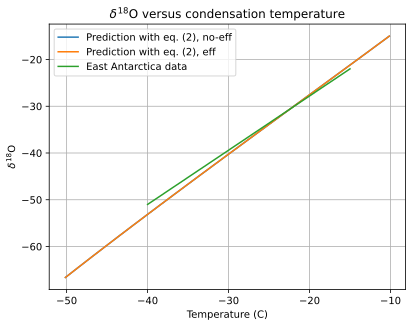

In [20]:
T_ticks = (-50, -40, -30, -20, -10)
n_points = 9
delta_18O_from_fig1 = np.linspace(-51, -22, n_points) * PER_MILLE
T_from_fig1 = np.linspace(-40, -15, n_points)
K2C = formulae.trivia.K2C


for i in Si_choices:
    pyplot.plot(
        K2C(temperature[::-1]),
        in_unit(delta_18O[i][::-1], PER_MILLE),
        label=f"Prediction with eq. (2), {i}",
    )

pyplot.plot(
    T_from_fig1, in_unit(delta_18O_from_fig1, PER_MILLE), label="East Antarctica data"
)
pyplot.gca().set(
    title="$\\delta^{18}$O versus condensation temperature",
    xlabel="Temperature (C)",
    ylabel="$\\delta^{18}$O",
    xticks=T_ticks,
)
pyplot.grid()
pyplot.legend()
show_plot("fig_1")

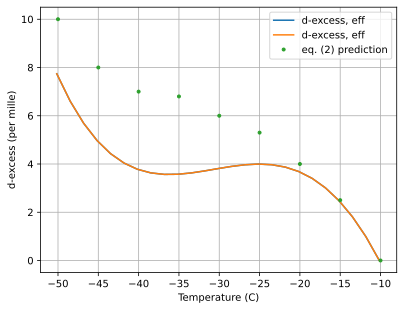

In [21]:
d_excess_from_fig2 = np.array((10, 8, 7, 6.8, 6, 5.3, 4, 2.5, 0)) * PER_MILLE
T_from_fig2 = np.linspace(-50, -10, n_points)

for Si_choice in Si_choices:
    pyplot.plot(
        K2C(temperature[::-1]),
        in_unit(d_excess[Si_choice], PER_MILLE)[::-1],
        label=f"d-excess, {Si_choice}",
    )

pyplot.plot(
    T_from_fig2, in_unit(d_excess_from_fig2, PER_MILLE), ".", label="eq. (2) prediction"
)
pyplot.gca().set(xlabel="Temperature (C)", ylabel="d-excess (per mille)")
pyplot.grid()
pyplot.legend()
show_plot("fig_2")